# LLHP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate_from_llhp

In [2]:
parse_dims = ['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'energy', 'track_fraction']
def parse(stats):
    out = {}
    out['mean'] = {}
    out['std'] = {}
    out['mle'] = {}
    out['map'] = {}    
    stats = [s.strip() for s in stats]
    print '\n'.join(stats)
    res = stats[4:12]
    for r in res:
        dim, p, e = [float(x) for x in r.split()]
        out['mean'][parse_dims[int(dim)-1]] = p
        out['std'][parse_dims[int(dim)-1]] = e
    out['mean']['track_energy'] = out['mean']['energy'] * out['mean']['track_fraction']
    out['mean']['cascade_energy'] = out['mean']['energy'] * (1 - out['mean']['track_fraction'])
    out['std']['track_energy'] = out['std']['energy'] * out['mean']['track_fraction']
    out['std']['cascade_energy'] = out['std']['energy'] * (1 - out['mean']['track_fraction'])
    
    res = stats[15:23]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['mle'][parse_dims[int(dim)-1]] = p
    out['mle']['track_energy'] = out['mle']['energy'] * out['mle']['track_fraction']
    out['mle']['cascade_energy'] = out['mle']['energy'] * (1 - out['mle']['track_fraction'])
    
    res = stats[26:34]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['map'][parse_dims[int(dim)-1]] = p
    out['map']['track_energy'] = out['map']['energy'] * out['map']['track_fraction']
    out['map']['cascade_energy'] = out['map']['energy'] * (1 - out['map']['track_fraction'])
    
    return out

In [3]:
# this looks nice
#event = 190
#quite nice one
#event = 33
# this one's fucked
#event = 142
#this one's spot on 80 GeV
#event = 133
# a normal one
#event = 7

#failed
#event = 42
#event = 41
#event = 55

#bad
#event = 80

# crazy
#event = 0
# bi-modal
#event = 7
#event = 12

# what the fuck with 26?
# evt 2 has llh > inf
file = '0.0'
event = 0

#llhp_data = np.load('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-llhp.npy'%event)
#llhp_data = np.load('/data/justin/retro/recos/2018-03-28/tblptckvlog/0/evt%i-llhp.npy'%event)
#llhp_data = np.load('/data/justin/retro/recos/2018-04-06.0/14600/13.0/evt%i-llhp.npy'%event)
llhp_data = np.load('/data/peller/retro/recos/2018.04.26_pegleg/14600/'+file+'/evt%i-llhp.npy'%event)
with open('/data/peller/retro/recos/2018.04.26_pegleg/14600/'+file+'/evt%i-multinest_meta.pkl'%event, 'rb') as f:
    meta = pickle.load(f)

#new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

#llhp_data.dtype.names = new_names

llhp = pn.PointData(llhp_data)

#with open('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-stats.dat'%event, 'r') as f:
#with open('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-stats.dat'%event, 'r') as f:
#    mn_stats = f.readlines()
#mn_stats = parse(mn_stats)

truth_file = np.load('/data/icecube/sim/ic86/retro/14600/'+file+'/truth.npy')
truth = {}
for name in truth_file.dtype.names:
    truth[name] = truth_file[name][event]
truth['track_azimuth'] = truth['azimuth']
truth['track_zenith'] = np.arccos(truth['coszen'])
truth['track_energy'] = truth['highest_energy_daughter_energy']

pegleg_file = np.load('/data/icecube/sim/ic86/retro/14600/'+file+'/recos/Pegleg_Fit_MN.npy')
pegleg = {}
for name in pegleg_file.dtype.names:
    pegleg[name] = pegleg_file[name][event]
    
spe_file = np.load('/data/icecube/sim/ic86/retro/14600/'+file+'/recos/SPEFit2.npy')
spe = {}
for name in spe_file.dtype.names:
    spe[name] = spe_file[name][event]

In [4]:
np.sum(llhp['llh'] > np.nanmax(llhp['llh'] - 15.5))

11692

In [5]:
bins = pn.Grid()

bins['x'].edges = np.linspace(truth['x'] - 50 , truth['x'] + 50, 101)
bins['y'].edges = np.linspace(truth['y'] - 50 , truth['y'] + 50, 101)
bins['z'].edges = np.linspace(truth['z'] - 50 , truth['z'] + 50, 101)
bins['time'].edges = np.linspace(truth['time'] - 150 , truth['time'] + 150, 101)
bins['track_azimuth'].edges = np.linspace(0, 2*np.pi, 101)
bins['track_zenith'].edges = np.linspace(0, np.pi, 101)
bins['cascade_azimuth'].edges = np.linspace(0, 2*np.pi, 101)
bins['cascade_zenith'].edges = np.linspace(0, np.pi, 101)
bins['track_energy'].edges = np.linspace(0 , 50, 101)
bins['cascade_energy'].edges = np.linspace(0 , 50, 101)

In [6]:
data = {}
data['xy'] = pn.GridData(bins['x','y'])
data['xt'] = pn.GridData(bins['x','time'])
data['xz'] = pn.GridData(bins['x','z'])
data['tz'] = pn.GridData(bins['time','z'])
data['azzen'] = pn.GridData(bins['track_azimuth','track_zenith'])
#data['cscd_azzen'] = pn.GridData(bins['cascade_azimuth','cascade_zenith'])
data['ezen'] = pn.GridData(bins['track_energy','track_zenith'])
data['ten'] = pn.GridData(bins['time','track_energy'])
data['tzen'] = pn.GridData(bins['time','track_zenith'])
data['energy'] = pn.GridData(bins['cascade_energy','track_energy'])

In [7]:
for key in data.keys():
    data[key]['llh'] = llhp.histogram('llh', function=np.nanmax)
    data[key]['count'] = llhp.histogram('llh', method='count')

In [8]:
def plot_estimator(ax, estimator, var_x, var_y, est_var='weighted_median', color='w', ms=10):
        ax.errorbar(estimator[est_var][var_x],
                    estimator[est_var][var_y],
                    marker='o',
                    c=color,
                    markeredgecolor='k',
                    ms=ms)
        ax.errorbar(estimator['low'][var_x],
                    estimator[est_var][var_y],
                    marker='>',
                    c=color,
                    markeredgecolor='k',
                    ms=ms)
        ax.errorbar(estimator['high'][var_x],
                    estimator[est_var][var_y],
                    marker='<',
                    c=color,
                    markeredgecolor='k',
                    ms=ms)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['low'][var_y],
                    marker='^',
                    c=color,
                    markeredgecolor='k',
                    ms=ms)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['high'][var_y],
                    marker='v',
                    c=color,
                    markeredgecolor='k',
                    ms=ms)

In [9]:
def plot(fig, ax, key, data, estimator, truth, spe={}, var='llh'):
    if var == 'llh':
        data[key].plot_map(fig, ax, var, cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key][var])-9.3, vmax=np.nanmax(data[key][var]))
    else:
        data[key].plot_map(fig, ax, var, cmap='Spectral_r', cbar=True)        
    plot_estimator(ax, estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
    ax.plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w', markeredgecolor='k')
    ax.plot(pegleg[data[key].grid.vars[0]], pegleg[data[key].grid.vars[1]], ms=20, marker='*', color='yellow', markeredgecolor='k')
    try:
        ax.plot(spe[data[key].grid.vars[0]], spe[data[key].grid.vars[1]], ms=20, marker='*', color='blue', markeredgecolor='k')
    except KeyError:
        pass
    ax.plot(llhp[np.argmax(llhp['llh'])][data[key].grid.vars[0]], llhp[np.argmax(llhp['llh'])][data[key].grid.vars[1]], ms=20, marker='*', color='k', markeredgecolor='w')

In [10]:
estimator = estimate_from_llhp(llhp.data, meta=meta)
#estimator = estimate_from_llhp(llhp.data, percentile_nd=0.99, prob_weights=True)
#estimator_nometa = estimate_from_llhp(llhp.data, percentile_nd=0.90)
#print estimator

In [11]:
estimator['best']

OrderedDict([('time', 9640.885),
             ('x', 23.921906),
             ('y', -94.29744),
             ('z', -394.9513),
             ('track_azimuth', 2.1268098),
             ('track_zenith', 2.9079583),
             ('track_energy', 1.0552695),
             ('cascade_energy', 2.3598902)])

In [12]:
estimator['high']

OrderedDict([('time', 9652.197073644422),
             ('x', 30.96071044100248),
             ('y', -88.25688068454548),
             ('z', -393.7061246637663),
             ('track_azimuth', 2.502933332130672),
             ('track_zenith', 3.000435528268516),
             ('track_energy', 2.9679453372955322),
             ('cascade_energy', 4.9197221628472345)])

In [13]:
pegleg

{'azimuth': 1.2158235,
 'cascade_energy': 5.663837,
 'energy': 5.2825146,
 'time': 9637.131,
 'track_azimuth': 1.2158235,
 'track_energy': 2.22,
 'track_zenith': 2.9906714,
 'x': 22.113842,
 'y': -94.07709,
 'z': -398.14746,
 'zenith': 2.9906714}

In [14]:
truth['cascade_zenith'] = np.arccos(truth['cascade_coszen'])

In [15]:
truth['energy']

3.8629646354203246

In [16]:
stats.chi2.ppf(0.95, 8)

15.507313055865453

/home/peller/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


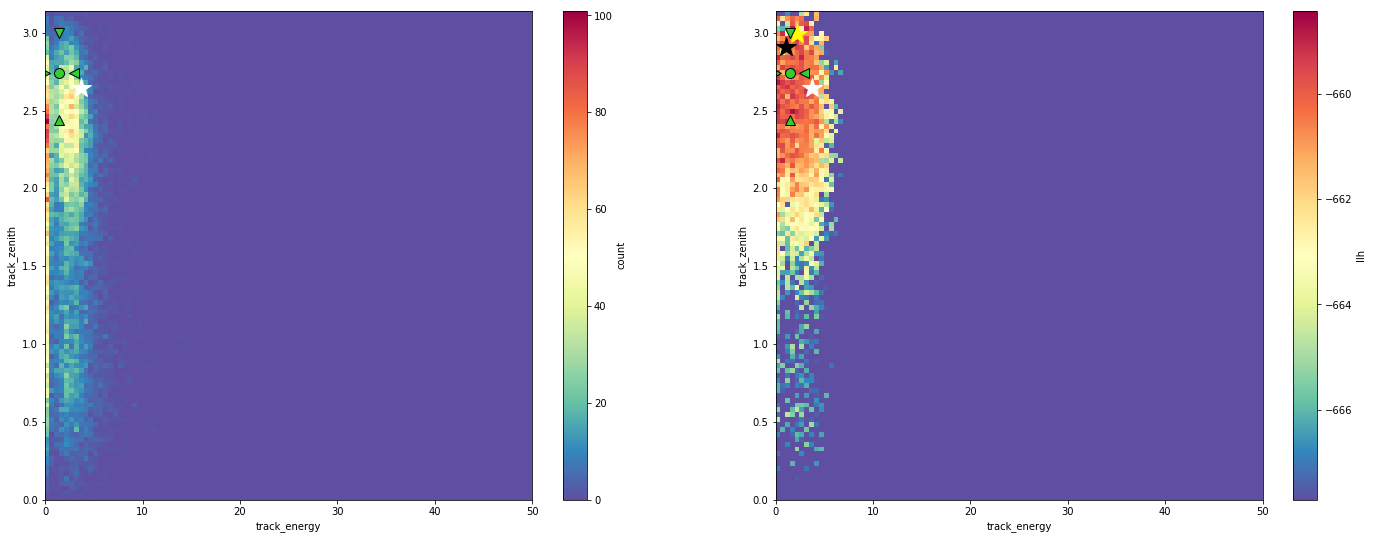

In [17]:
fig, axes = plt.subplots(figsize=(24, 9), ncols=2, nrows=1)
key = 'ezen'
data[key].plot_map(fig, axes[0], 'count', cmap='Spectral_r', cbar=True)
data[key].plot_map(fig, axes[1], 'llh', cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key]['llh'])-9.3, vmax=np.nanmax(data[key]['llh']))
#data[key].plot_map(fig, axes[1], 'llh', cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key]['llh'])-15.5, vmax=np.nanmax(data[key]['llh']))

fig.savefig('llhp.png')
plot_estimator(axes[1], estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
#plot_estimator(axes[1], estimator_nometa, data[key].grid.vars[0], data[key].grid.vars[1], color='b')
plot_estimator(axes[0], estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
#plot_estimator(axes[0], estimator_nometa, data[key].grid.vars[0], data[key].grid.vars[1], color='b', est_var='median')
axes[0].plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
axes[1].plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
axes[1].plot(pegleg[data[key].grid.vars[0]], pegleg[data[key].grid.vars[1]], ms=20, marker='*', color='yellow')
axes[1].plot(llhp[np.argmax(llhp['llh'])][data[key].grid.vars[0]], llhp[np.argmax(llhp['llh'])][data[key].grid.vars[1]], ms=20, marker='*', color='k')

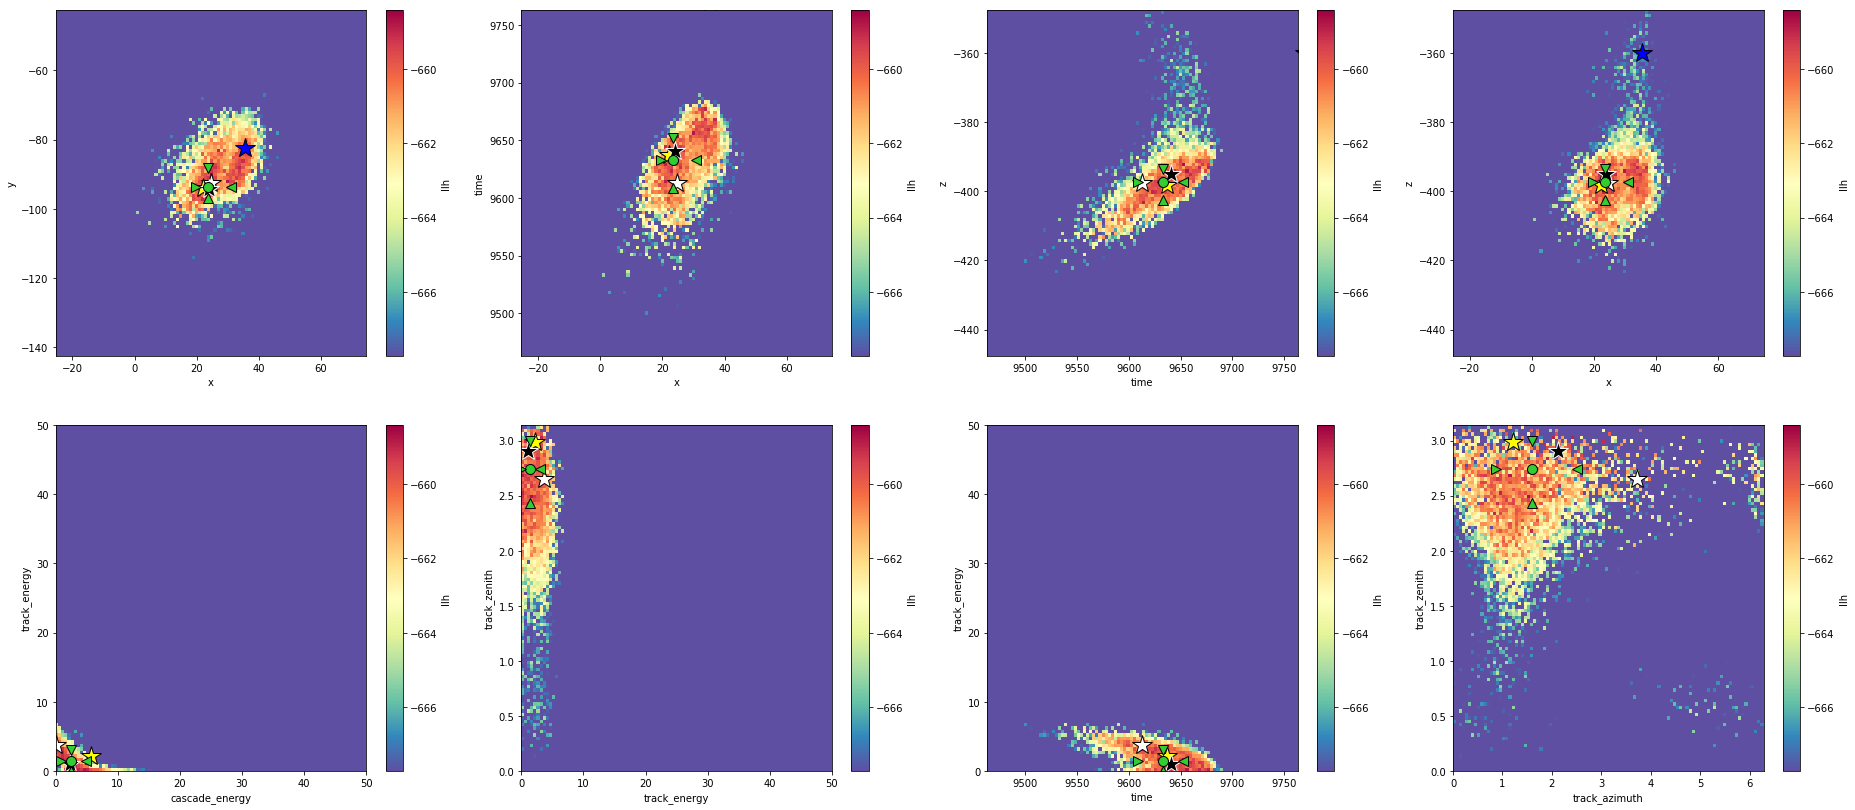

In [18]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
plot(fig, axes[0,0], 'xy', data, estimator, truth, spe)
plot(fig, axes[0,1], 'xt', data, estimator, truth, spe)
plot(fig, axes[0,2], 'tz', data, estimator, truth, spe)
plot(fig, axes[0,3], 'xz', data, estimator, truth, spe)
plot(fig, axes[1,0], 'energy', data, estimator, truth, spe)
plot(fig, axes[1,1], 'ezen', data, estimator, truth, spe)
plot(fig, axes[1,2], 'ten', data, estimator, truth, spe)
plot(fig, axes[1,3], 'azzen', data, estimator, truth, spe)
#fig.savefig('before.png')

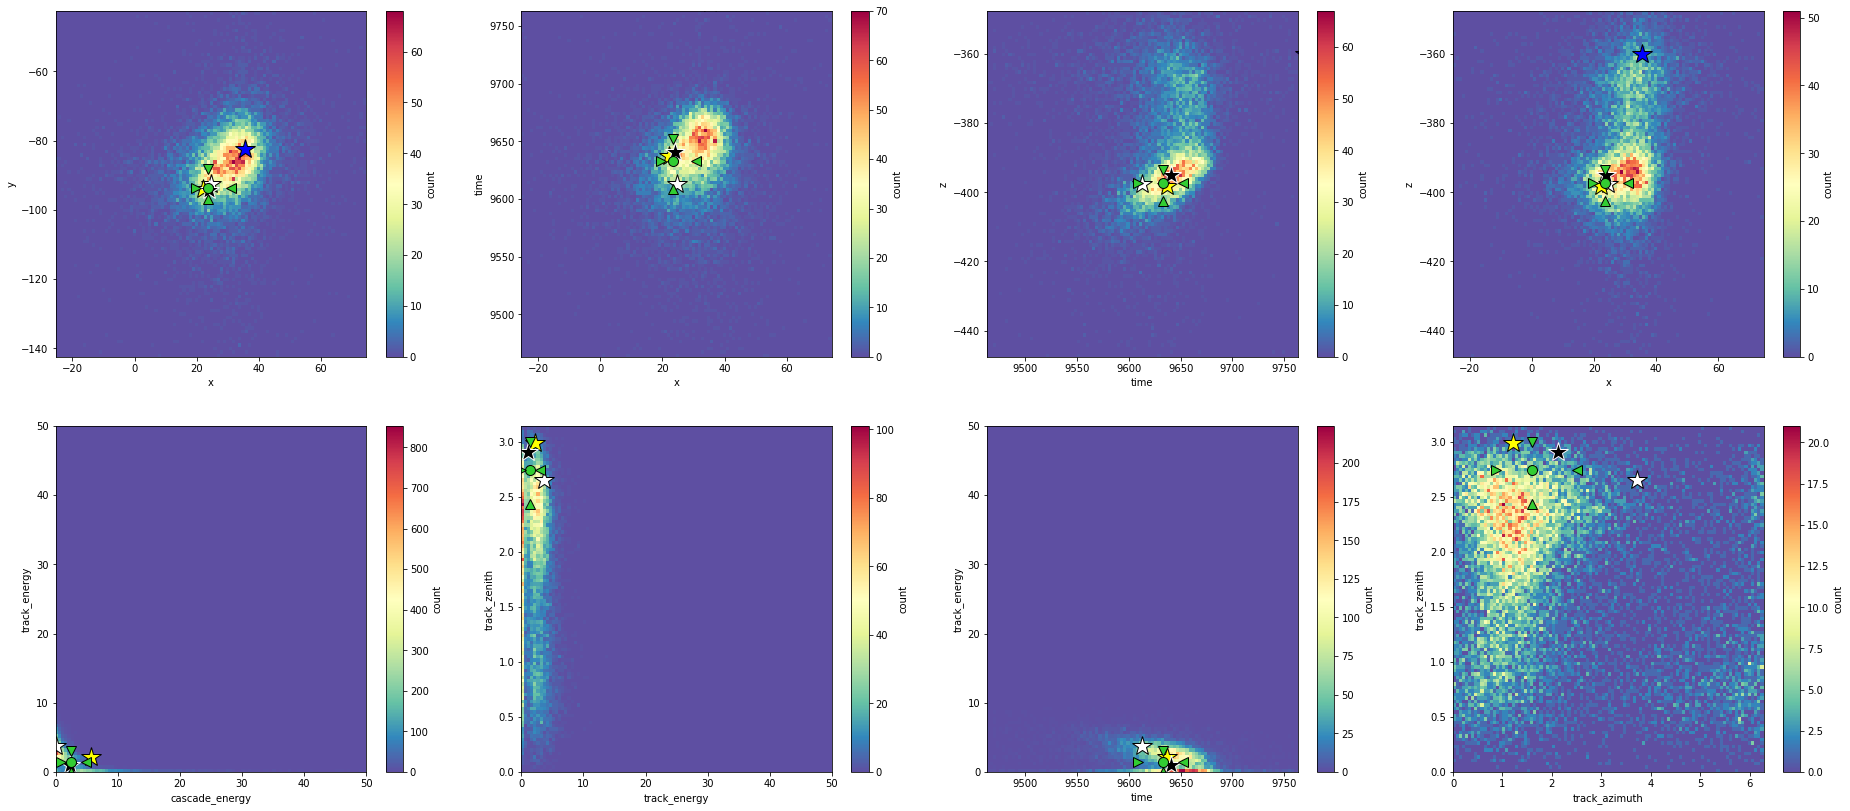

In [19]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
plot(fig, axes[0,0], 'xy', data, estimator, truth, spe, var='count')
plot(fig, axes[0,1], 'xt', data, estimator, truth, spe, var='count')
plot(fig, axes[0,2], 'tz', data, estimator, truth, spe, var='count')
plot(fig, axes[0,3], 'xz', data, estimator, truth, spe, var='count')
plot(fig, axes[1,0], 'energy', data, estimator, truth, spe, var='count')
plot(fig, axes[1,1], 'ezen', data, estimator, truth, spe, var='count')
plot(fig, axes[1,2], 'ten', data, estimator, truth, spe, var='count')
plot(fig, axes[1,3], 'azzen', data, estimator, truth, spe, var='count')
#fig.savefig('before.png')

In [265]:
np.argmax(llhp['llh'])

44104

In [2837]:
len(llhp.data)

36259

In [1993]:
chi2 = stats.chi2.sf(-2*(llhp['llh'] - np.max(llhp['llh'])), 1)

In [1994]:
chi2

array([6.90174972e-47, 5.52916145e-40, 8.93200444e-66, ...,
       5.06709232e-10, 3.25261339e-08, 1.29984614e-05])

In [2018]:
llhp[np.argmax(llhp['llh'])]

(-907.95575, 9786.155, 94.10807, 33.126106, -390.41876, 2.6409802, 4.004354, 9.954413, 12.987333)

In [2389]:
llhp.data[-1]

(-807.24225, 9714.395, 40.495907, -76.6322, -357.54385, 0.9174522, 4.4671626, 12.836641, 24.595581)

In [2957]:
sorted(-llhp['llh'])

[628.90027,
 632.3535,
 632.55023,
 632.9467,
 633.0263,
 633.09766,
 633.1117,
 633.2996,
 633.30414,
 633.3496,
 633.3576,
 633.36676,
 633.42584,
 633.426,
 633.4334,
 633.4452,
 633.49243,
 633.53107,
 633.5343,
 633.54193,
 633.5597,
 633.5619,
 633.5665,
 633.56665,
 633.5816,
 633.5841,
 633.5851,
 633.5851,
 633.58795,
 633.5942,
 633.6018,
 633.61273,
 633.62286,
 633.6239,
 633.6326,
 633.6353,
 633.63696,
 633.6411,
 633.64197,
 633.65094,
 633.6521,
 633.65717,
 633.6576,
 633.6604,
 633.667,
 633.6676,
 633.67664,
 633.6858,
 633.686,
 633.6891,
 633.6956,
 633.7004,
 633.7029,
 633.706,
 633.7103,
 633.71124,
 633.71344,
 633.71436,
 633.7166,
 633.7191,
 633.71936,
 633.7195,
 633.72565,
 633.7278,
 633.72815,
 633.72833,
 633.7297,
 633.73065,
 633.73267,
 633.73395,
 633.73535,
 633.7382,
 633.7386,
 633.73895,
 633.7393,
 633.7418,
 633.7418,
 633.7437,
 633.7461,
 633.74634,
 633.7473,
 633.7477,
 633.74805,
 633.75134,
 633.75525,
 633.7559,
 633.7569,
 633.7575,
 6

In [2054]:
np.average(llhp['track_zenith'][llhp['llh'] > - 920])

1.8308367

In [1999]:
np.exp((llhp['llh'] - np.max(llhp['llh']))[llhp['llh'] > - 430])**(1./8)

array([], dtype=float32)

In [2000]:
llhp['llh']


array([-646.6995 , -630.8853 , -690.0172 , ..., -562.63184, -558.58154,
       -552.8116 ], dtype=float32)

In [2053]:
np.max(llhp['track_zenith'])

3.1247323

In [2320]:
l = range(10)

In [2326]:
l[0:9]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [2339]:
e = np.empty(shape=10, dtype=dtype)

In [2330]:
dtype = np.dtype([('a',np.float32), ('b',np.int)])

In [2341]:
e['b'] = 1

In [2338]:
for a in e: print a

In [2342]:
e

array([(-765.9519 , 1), (-673.13245, 1), (-607.6552 , 1), (-604.46216, 1),
       (-592.2487 , 1), (-721.2773 , 1), (-600.5176 , 1), (-681.5389 , 1),
       (-607.9268 , 1), (-585.28516, 1)],
      dtype=[('a', '<f4'), ('b', '<i8')])